## Challenge Description

<font size=3>Company XYZ has started a new referral program on Oct, 31. Each user who refers a new user will get $10 in credit when the new user buys something.

<font size=3>The program has been running for almost a month and the Growth Product Manager wants to know if it’s been successful. She is very excited because, since the referral program started, the company saw a spike in number of users and wants you to be able to give her some data she can show to her boss.

- Can you estimate the impact the program had on the site?


- Based on the data, what would you suggest to do as a next step?


- The referral program wasn’t really tested in a rigorous way. It simply started on a given day for all users and you are drawing conclusions by looking at the data before and after the test started. What kinds of risks this approach presents? Can you think of a better way to test the program and measure its impact?

---

### Load data

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('referral.csv')
data.head()

,user_id,date,country,money_spent,is_referral,device_id
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG
3,7,2015-10-03,UK,73,0,PRGXJZAJKMXRH
4,7,2015-10-03,MX,35,0,PRGXJZAJKMXRH


In [6]:
# split users into control and test groups based on time
data['test'] = 0
data.loc[data[data['date']>='2015-10-31'].index, 'test'] = 1

In [7]:
data.test.value_counts()

1    50000
0    47341
Name: test, dtype: int64

In [63]:
data.groupby('test').is_referral.value_counts().unstack()

is_referral,0,1
test,,
0,47341.0,NaN
1,21983.0,28017.0


In [65]:
data.groupby('test').agg({'money_spent':'mean','user_id':'nunique'})

,money_spent,user_id
test,,
0,42.381783,5000
1,46.880060,18397


---

<font size=5> Q1: Estimate the impact the program had on the site

<font size=4> 1.1 Sanity check

In [19]:
# check days between two groups
control_days = data[data['date']<'2015-10-31']['date'].nunique()
test_days = data[data['date']>='2015-10-31']['date'].nunique()
print('control days: ',control_days, '\ntest_days:',test_days)

control days:  28 
test_days: 28


<font size=4>1.2 effect test

- <font size=3>define the metrics:
  - the number of daily transactions
  - the number of daily users
  - the amount of daily money spent

<font size=3>a. daily number of transactions

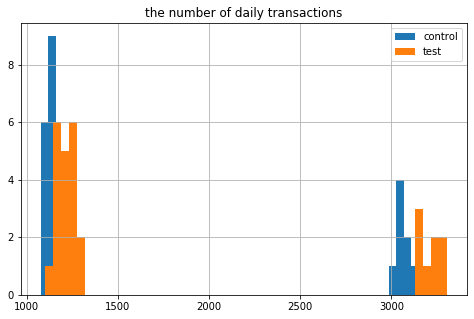

In [238]:
plt.figure(figsize=(8,5))
data[data['test']==0].groupby('date').size().hist(bins=50)
data[data['test']==1].groupby('date').size().hist(bins=50)
plt.title('the number of daily transactions')
plt.legend(['control','test'])
plt.show()

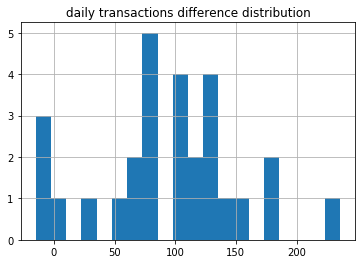

In [241]:
diff = data[data['test']==1].groupby('date').size().values - data[data['test']==0].groupby('date').size().values
diff = pd.DataFrame(diff)
diff.hist(bins=20)
plt.title('daily transactions difference distribution')
plt.show()

In [134]:
## check the daily transactions metric
stat, pvalue = stats.ttest_ind(data[data['test']==0].groupby('date').size(),
                               data[data['test']==1].groupby('date').size(),equal_var=False)
pvalue/2

0.34825710254713316

- <font size=3> above result shows there is no difference in daily transactions between control and test groups
    
    let's break it down to different segments:

In [243]:
# check the daily transactions in different segments
print('{0:10s} {1:>15s} {2:>10s}'.format('Country','Difference', 'P-Value'))
print('-' * 40)
for col in data.country.unique():
    cont = data[(data['country']==col)&(data['test']==0)]
    exp = data[(data['country']==col)&(data['test']==1)]
    result = stats.ttest_ind(cont.groupby('date').size(),
                            exp.groupby('date').size(),equal_var=False)
    diff = exp.groupby('date').size().mean() - cont.groupby('date').size().mean()
    print('{0:10s} {1:15f} {2:10f}'.format(col, diff, result.pvalue/2))

Country         Difference    P-Value
----------------------------------------
FR               61.571429   0.058996
CA              -17.142857   0.233985
UK               24.750000   0.261183
MX               37.535714   0.032430
DE              -68.107143   0.011798
US              -18.857143   0.307801
IT               47.071429   0.057454
ES               37.892857   0.072638
CH               -9.750000   0.003072


- country 'DE' and 'CH' has a negative significance, which means the number of daily transactions drops significantly in the two countries.
- the new referral program performs pretty well in country 'MX', and the daily transactions increased significantlly in country 'MX'.
- the program doesn't seem have any significant effect on other countries

<font size=3>b. daily number of users

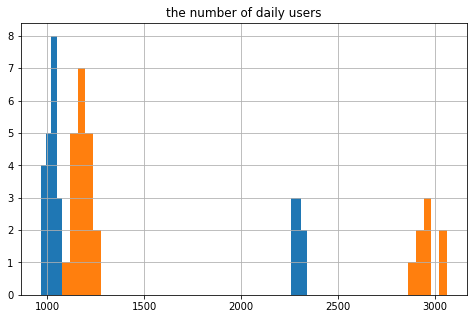

In [187]:
plt.figure(figsize=(8,5))
data[data['test']==0].groupby('date').user_id.nunique().hist(bins=50)
data[data['test']==1].groupby('date').user_id.nunique().hist(bins=50)
plt.title('the number of daily users')
plt.show()

In [167]:
## check the number of daily users metric
stat, pvalue = stats.ttest_ind(data[data['test']==0].groupby('date').user_id.nunique(),
                               data[data['test']==1].groupby('date').user_id.nunique(),equal_var=False)
pvalue/2

0.05954546934016834

In [171]:
# check the number of daily users in different segments
print('{0:10s} {1:>15s} {2:>10s}'.format('Country','Difference', 'P-Value'))
print('-' * 40)
for col in data.country.unique():
    cont = data[(data['country']==col)&(data['test']==0)]
    exp = data[(data['country']==col)&(data['test']==1)]
    result = stats.ttest_ind(cont.groupby('date').user_id.nunique(),
                            exp.groupby('date').user_id.nunique(),equal_var=False)
    diff = exp.groupby('date').user_id.nunique().mean() - cont.groupby('date').user_id.nunique().mean()
    print('{0:10s} {1:15f} {2:10f}'.format(col, diff, result.pvalue/2))

Country         Difference    P-Value
----------------------------------------
FR               66.035714   0.041124
CA              -14.107143   0.268256
UK               30.750000   0.204398
MX               38.714286   0.026203
DE              -61.714286   0.015665
US              -12.071429   0.368860
IT               49.571429   0.043911
ES               39.821429   0.057954
CH               -9.642857   0.003142


<font size=3>c. the amount of daily money spent

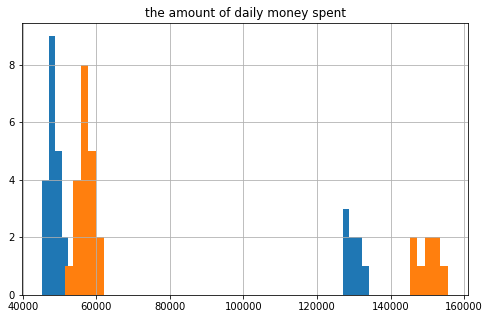

In [208]:
plt.figure(figsize=(8,5))
data[data['test']==0].groupby('date').money_spent.sum().hist(bins=50)
data[data['test']==1].groupby('date').money_spent.sum().hist(bins=50)
plt.title('the amount of daily money spent')
plt.show()

In [199]:
## check the amount of daily money spent metric
stat, pvalue = stats.ttest_ind(data[data['test']==0].groupby('date').money_spent.sum(),
                               data[data['test']==1].groupby('date').money_spent.sum(),equal_var=False)
pvalue/2

0.13519402252277665

In [204]:
# check the amount of daily money spent in different segments
print('{0:10s} {1:>15s} {2:>10s}'.format('Country','Difference', 'P-Value'))
print('-' * 40)
for col in data.country.unique():
    cont = data[(data['country']==col)&(data['test']==0)]
    exp = data[(data['country']==col)&(data['test']==1)]
    result = stats.ttest_ind(cont.groupby('date').money_spent.sum(),
                            exp.groupby('date').money_spent.sum(),equal_var=False)
    diff = exp.money_spent.sum() - cont.money_spent.sum()
    print('{0:10s} {1:15f} {2:10f}'.format(col, diff, result.pvalue/2))

Country         Difference    P-Value
----------------------------------------
FR            90993.000000   0.031843
CA            11536.000000   0.351704
UK            83521.000000   0.048490
MX            57617.000000   0.009670
DE           -51598.000000   0.081459
US            32380.000000   0.248874
IT            71172.000000   0.025730
ES            56334.000000   0.037522
CH           -14348.000000   0.006941


### The above results shows:

#### Although the new referral program increase the three metrics: daily transactions, daily users, daily money spent, but none of them are significant. Let's break down into different countries:

- For daily transactions:
  1. - country 'DE' and 'CH' has a negative significance, which means the number of daily transactions drops significantly in the two countries.
  2. the new referral program performs pretty well in country 'MX', and the daily transactions increased significantlly in country 'MX'.
  3. the program doesn't seem have any significant effect on other countries

- For daily users:
  1. daily users are significantly droped in countries 'CH' and 'DE'
  2. countries 'MX','IT','FR','ES' increased the daily users significantly

- For daily money spent:
  1. the program decrease the daily money spent in country 'CH' significantly
  2. the daily money spent significantly increased in countries 'FR','UK','MX','IT' and 'ES'.

---

<font size=4>Q2: Based on the data, what would you suggest to do as a next step?

From the above results:

- First, I'll suggest to re-check the experiment setup, since the test and control group are not under the same period of time, we may need to re-design the experiment.

- From the above results we can see that for different countries, the users shows different behaviors. So I'll suggest to dive deeper for the countries which perform bad, to find out the reason; and for the countries where program have no effect, I'll suggest to do some user experience research or survey to figure out the reason; for the countries which perform well, do additional experiment after re-designing the experiment to double check the results.

---

<font size=4>Q3: What kinds of risks this approach presents? Can you think of a better way to test the program and measure its impact?

Here are some issues in the ab test:

- The test and control group are not comparable in the referral program ab test experiment. It takes the transactions before Oct. 31 as control group while the transactions after Oct. 31 as test group, and this causes an issue that the referral program isn't the only difference between two groups, since there may be other factors that can influence the difference in metrics between two groups, such as holiday season, and other factors.

- Also, the ab test split the transactions into control and test groups, which means a same user can be assigned to test and control groups at the same time, so that it's hard to make the test and control groups independent for each other. 

So, in order to avoid this issue, we may need to re-design the ab test:

- make the control and test groups are under the same period of time

- randomly split the users into two groups, and show one of the groups the new referral program

- run the experiment long enough to cover user behaviors in different time periods, then analyze the results.